In [ ]:
from google.colab import drive
#specify project directory in drive eg /content/drive/NLUProject
# drive.flush_and_unmount()
drive.mount('/content/drive')

#define necessary imports
import time
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from torch.utils.data import Dataset, DataLoader

import gensim

Mounted at /content/drive


In [ ]:
#import the data

def read_lyrics(filename):
  df = pd.read_csv(filename) 
  return df

df = read_lyrics("drive/MyDrive/NLU Project/data/lyrics/labeled_lyrics_cleaned.csv")


# Concatenate review title and review body
df["lyric"] = df["song"] + " " + df["seq"]
#drop unnecessary data
df = df.drop(labels=["song", "seq", "Unnamed: 0", "label"], axis = 1)

# Useful data from df
unique_user_id = df.artist.unique()
print(df.groupby('artist').count())

             lyric
artist            
ANTiSEEN         3
APB              1
ASG              1
ATB             56
ATC              3
...            ...
pre)Thing        1
superGARAGE      1
t.A.T.u.        18
theSTART         4
tobyMac         49

[14691 rows x 1 columns]


In [ ]:
#get the unique artists and count them
uniqueArtists = np.sort(df["artist"].unique())
IDDictionary = {}
for i in range(len(uniqueArtists)):
  IDDictionary[uniqueArtists[i]] = len(IDDictionary)

df["artist_label"] = df["artist"].map(IDDictionary)


print("Unique artists:",len(df["artist_label"].unique()))

Unique artists: 14691


In [ ]:
# Get top 1000 artists
keep_artists = df['artist'].value_counts().nlargest(1000)

# Remove artists not in top 1000
df = df[df['artist'].isin(set(keep_artists.index))]

df = df.reset_index(drop=True)
len(df["artist_label"].unique())
keep_artists.head(50)

Elvis Presley           821
Frank Sinatra           779
Ella Fitzgerald         751
Johnny Cash             598
Willie Nelson           587
George Jones            509
Neil Diamond            434
Elvis Costello          411
Prince                  391
Dean Martin             380
The Rolling Stones      363
Sarah Vaughan           348
Merle Haggard           338
Diana Ross              304
The Beatles             304
George Strait           303
Barry Manilow           301
Depeche Mode            287
Waylon Jennings         285
The Beach Boys          268
Jethro Tull             263
Aretha Franklin         262
Jerry Lee Lewis         261
Andy Williams           259
The Kinks               255
Alice Cooper            251
Emmylou Harris          247
Oscar Peterson          246
They Might Be Giants    244
Roy Orbison             244
The Supremes            241
Kiss                    240
Rod Stewart             237
Bon Jovi                223
The Fall                222
Iggy Pop            

In [ ]:
# Up and Down SAMPLE TO BALANCE DATA
lst = []
for class_index, group in df.groupby('artist'):
    lst.append(group.sample(250, replace=True))
df_balanced = pd.concat(lst)
df_balanced = df_balanced.reset_index(drop=True)
df_balanced.head()

,artist,lyric,artist_label
0,ATB,Love Will Find You I believe it's all inside y...,3
1,ATB,Made of Glass A change is coming I can sense i...,3
2,ATB,"Feel Alive You've killed my days, my innermost...",3
3,ATB,Killer [Radio Edit] It's the loneliness\r\ntha...,3
4,ATB,The Summer [Ibiza Influence Version] Irrationa...,3


In [ ]:
df_balanced['artist'].value_counts().nlargest(1000)

ATB              250
All About Eve    250
Anouk            250
Annihilator      250
Al Jarreau       250
                ... 
Z-Ro             250
Zebrahead        250
blink-182        250
k.d. lang        250
tobyMac          250
Name: artist, Length: 1000, dtype: int64

In [ ]:
# Tokenise the lyric data
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()

# Make new column with list of tokens for each review
df_balanced["lyric_tokens"] = df_balanced["lyric"].apply(tt.tokenize)
df_balanced.head()

,artist,lyric,artist_label,lyric_tokens
0,ATB,Love Will Find You I believe it's all inside y...,3,"[Love, Will, Find, You, I, believe, it's, all,..."
1,ATB,Made of Glass A change is coming I can sense i...,3,"[Made, of, Glass, A, change, is, coming, I, ca..."
2,ATB,"Feel Alive You've killed my days, my innermost...",3,"[Feel, Alive, You've, killed, my, days, ,, my,..."
3,ATB,Killer [Radio Edit] It's the loneliness\r\ntha...,3,"[Killer, [, Radio, Edit, ], It's, the, lonelin..."
4,ATB,The Summer [Ibiza Influence Version] Irrationa...,3,"[The, Summer, [, Ibiza, Influence, Version, ],..."


252.477224
159.4971778096836


{'boxes': [<matplotlib.lines.Line2D at 0x7fb79a7a3e90>],
 'caps': [<matplotlib.lines.Line2D at 0x7fb79a7aced0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb79a7a3490>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fb79a7b39d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fb79a7ac450>,
  <matplotlib.lines.Line2D at 0x7fb79a7ac990>]}

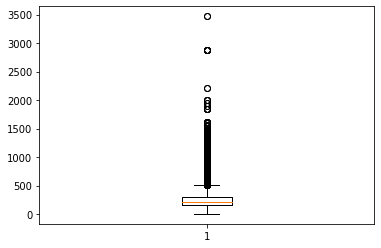

In [ ]:
#check the lengths of sequences
dfColumnAsList = df_balanced['lyric_tokens'].tolist()
listOfListLengths = [len(i) for i in dfColumnAsList]
print(np.mean(listOfListLengths))
print(np.std(listOfListLengths))

fig1, ax1 = plt.subplots()
ax1.boxplot(listOfListLengths)

In [ ]:
# Truncate token lists to 1000 tokens
for index, row in df_balanced.iterrows():
  if len(row['lyric_tokens']) > 1000:
    del row['lyric_tokens'][1000:]

251.83508
155.38169931299373


{'boxes': [<matplotlib.lines.Line2D at 0x7fb7a1650e10>],
 'caps': [<matplotlib.lines.Line2D at 0x7fb7a21a0490>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb7a21a14d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fb7a21a0f50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fb7a1671450>,
  <matplotlib.lines.Line2D at 0x7fb7a2112dd0>]}

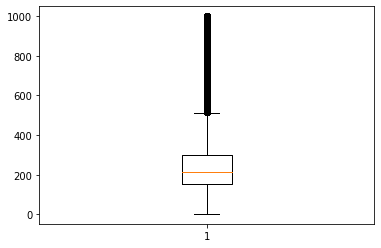

In [ ]:
#check the now updated sequence lengths
dfColumnAsList = df_balanced['lyric_tokens'].tolist()
listOfListLengths = [len(i) for i in dfColumnAsList]
print(np.mean(listOfListLengths))
print(np.std(listOfListLengths))

fig1, ax1 = plt.subplots()
ax1.boxplot(listOfListLengths)

COMMENTED OUT: PREPROCESSING FOR PRETRAINED EMBEDDINGS (DO NOT STORE WORDS THAT DO NOT EXIST IN THE DATASET'S VOCAB)

In [ ]:
#get all of the unique words in the data's vocab
# uniqueWordsInData = set(df_balanced["lyric_tokens"].explode().unique())

In [ ]:
# filename = 'drive/MyDrive/NLU Project/data/GloVe300dCommonCrawl/glove.840B.300d.txt'
 
# updatedFile = open("drive/MyDrive/NLU Project/data/GloVe300dCommonCrawl/lyric-reduced-glove.txt", "w")

# uniqueWordsInEmbeddings = set()

# with open(filename) as f:
#   for line in f.readlines():
#     currentVector = line.split()
#     if currentVector[0] in uniqueWordsInData:
#       updatedFile.write(line)
#       uniqueWordsInEmbeddings.add(currentVector[0])

# updatedFile.close()

In [ ]:
# #read in GloVe vectors

# input = 'drive/MyDrive/NLU Project/data/GloVe300dCommonCrawl/lyric-reduced-glove.txt'
# output = 'drive/MyDrive/NLU Project/data/GloVe300dCommonCrawl/lyric-gensim_glove.txt'

In [ ]:
# gensim.scripts.glove2word2vec.glove2word2vec(input, output)

In [ ]:
# # Load glove vectors into gensim model
# model = gensim.models.KeyedVectors.load_word2vec_format(output, binary=False)


In [ ]:
# oov_vector = np.random.rand(1, 300)
# model.add([unknownToken],oov_vector)

In [ ]:
# pad_vector = np.zeros((1,300))
# model.add([padToken],pad_vector)

In [ ]:
# # Save gensim model
# model.save('drive/MyDrive/NLU Project/data/lyric-glove_vectors.kv')

# print(len(uniqueWordsInEmbeddings))
# print(len(uniqueWordsInData))

In [ ]:
#define special tokens
unknownToken = "<unk>"
padToken = "<pad>"
#Load gensim model in
model = gensim.models.KeyedVectors.load('drive/MyDrive/NLU Project/data/preProcessedEmbeddings/lyric-glove_vectors.kv')
paddingID = model.vocab[padToken].index

In [ ]:
weights = torch.FloatTensor(model.vectors)

In [ ]:
df_balanced["lyric_tokens_reduced"] = df_balanced["lyric_tokens"]

for index, row in df_balanced.iterrows():
  current_list = []
  for token in row['lyric_tokens']:
    try:
      current_list.append(model.vocab[token].index)
    except KeyError:
      current_list.append(model.vocab[unknownToken].index)
  df_balanced.at[index, "lyric_tokens_reduced"] = current_list


In [ ]:
#show the preprocessed dataframe
df_balanced.head(50)

,artist,lyric,artist_label,lyric_tokens,lyric_tokens_reduced
0,ATB,Love Will Find You I believe it's all inside y...,3,"[Love, Will, Find, You, I, believe, it's, all,...","[674, 1192, 796, 91, 12, 475, 95219, 41, 855, ..."
1,ATB,Made of Glass A change is coming I can sense i...,3,"[Made, of, Glass, A, change, is, coming, I, ca...","[2564, 5, 2867, 77, 358, 10, 637, 12, 39, 915,..."
2,ATB,"Feel Alive You've killed my days, my innermost...",3,"[Feel, Alive, You've, killed, my, days, ,, my,...","[5507, 12192, 107855, 1996, 42, 249, 0, 42, 40..."
3,ATB,Killer [Radio Edit] It's the loneliness\r\ntha...,3,"[Killer, [, Radio, Edit, ], It's, the, lonelin...","[10736, 69, 1997, 4142, 70, 99819, 2, 22329, 1..."
4,ATB,The Summer [Ibiza Influence Version] Irrationa...,3,"[The, Summer, [, Ibiza, Influence, Version, ],...","[21, 2166, 69, 21483, 16700, 1916, 70, 50198, ..."
5,ATB,Take Me Over Looking down unaware of the world...,3,"[Take, Me, Over, Looking, down, unaware, of, t...","[1386, 1035, 1577, 2232, 190, 13498, 5, 2, 200..."
6,ATB,Fall Asleep Things that happen \r\nWhen you fa...,3,"[Fall, Asleep, Things, that, happen, When, you...","[3320, 42260, 2855, 15, 1213, 248, 18, 1182, 7..."
7,ATB,Underwater World Won't you have some of that?\...,3,"[Underwater, World, Won't, you, have, some, of...","[21577, 416, 107855, 18, 30, 83, 5, 15, 36, 10..."
8,ATB,I Can't Stand I can't stay\r\nI can't stay in ...,3,"[I, Can't, Stand, I, can't, stay, I, can't, st...","[12, 107855, 5846, 12, 101490, 746, 12, 101490..."
9,ATB,Killer 2000 So you want to be free?\nTo live y...,3,"[Killer, 2000, So, you, want, to, be, free, ?,...","[10736, 1001, 212, 18, 154, 4, 25, 189, 36, 18..."


In [ ]:
class lyricDataset(Dataset):
    """lyric dataset."""

    def __init__(self, df):
        self.df = df
        self.maxLenForDF = self.getMaximumLengthSequence()
        self.padReturningItems(self.maxLenForDF)
        self.sendListToTensors()

    def padReturningItems(self, lengthToPadTo):
        for index, row in self.df.iterrows():
            # if(index % 100 == 0):
            #   print(index)
            paddingNeeded = (lengthToPadTo - len(row['lyric_tokens_reduced']))
            if(paddingNeeded > 0):
                padData = [paddingID] * paddingNeeded
                self.df.at[index, 'lyric_tokens_reduced'] = row['lyric_tokens_reduced'] + padData

    def sendListToTensors(self):
        for index, row in self.df.iterrows():
            self.df.at[index, "lyric_tokens_reduced"] = torch.tensor(row['lyric_tokens_reduced'], dtype=torch.int)
            self.df.at[index, "artist_label"] = torch.tensor(row['artist_label'], dtype=torch.int)

    def __len__(self):
        return self.df.shape[0]

    def getMaximumLengthSequence(self):
        #print(df)
        dfColumnAsList = self.df['lyric_tokens_reduced'].tolist()
        listOfListLengths = [len(i) for i in dfColumnAsList]
        return max(listOfListLengths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        dfRowToReturn = self.df.iloc[idx]
        dictToReturn = {'input': dfRowToReturn['lyric_tokens_reduced'], 'label': dfRowToReturn['artist_label']}
        #print(dictToReturn)
        return dictToReturn

In [ ]:
# Split data into train, validate and test sets 70:15:15
np.random.seed(seed=6)
train, validate, test = np.split(df_balanced.sample(frac=1, random_state=6), 
                        [int(.7*len(df_balanced)), int(.85*len(df_balanced))])
              
print("TRAIN PERCENTAGE:      ", 100*train.shape[0]/len(df_balanced), "%")
print("VALIDATION PERCENTAGE: ", 100*validate.shape[0]/len(df_balanced), "%")
print("TEST PERCENTAGE:       ", 100*test.shape[0]/len(df_balanced), "%")

TRAIN PERCENTAGE:       70.0 %
VALIDATION PERCENTAGE:  15.0 %
TEST PERCENTAGE:        15.0 %


In [ ]:
train_dataset = lyricDataset(train)
validate_dataset = lyricDataset(validate)
test_dataset = lyricDataset(test)

In [ ]:
train_dataset.getMaximumLengthSequence()

1000

In [ ]:
torch.save(test_dataset, 'drive/MyDrive/NLU Project/data/PyTorchDataset/LyricTest.pt')
torch.save(validate_dataset, 'drive/MyDrive/NLU Project/data/PyTorchDataset/LyricValidate.pt')
torch.save(train_dataset, 'drive/MyDrive/NLU Project/data/PyTorchDataset/LyricTrain.pt')